### Load the data using the scikit learn datasets module

In [58]:
from sklearn.datasets import load_iris

iris_data = load_iris()

print(iris_data.keys())

X = iris_data.data
y = iris_data.target

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


### Split the dataset into training, validation and testing sets using the model_selection module

We will not use this method since this dataset is small (< 2000 samples), so we will use cross validation.

In [59]:
# from sklearn.model_selection import train_test_split

# # 1. First split: 80% Train+Val, 20% Test (The Vault)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 2. Second split: Split the 80% into 75% Train / 25% Val
# # (This results in 60% Train, 20% Val, 20% Test of the original total)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


### Implement a "leak-proof" cross validation pipleline instead of train, val, and test split 

If I scale the entire training set before running cross_val_score, the "validation" fold inside that CV has technically already influenced the mean and standard deviation of the training set. This is a subtle form of data leakage.

To fix this and strictly follow the "Scaling Wall" logic within Cross-Validation, we use a Pipeline. In Scikit-Learn, when you pass a Pipeline into cross_val_score, it is smart enough to perform the fit_transform only on the training folds and then transform on the validation fold for every single iteration.

In [60]:
#Split the data into training and testing sets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)


(120, 4)
(30, 4)


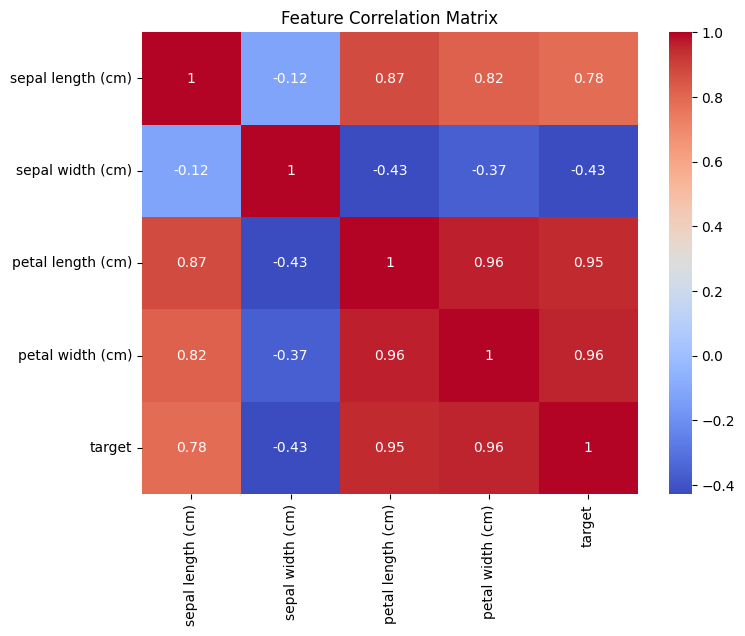

In [61]:
import pandas as pd
import seaborn as sns

# Create a temporary dataframe for analysis
df = pd.DataFrame(X, columns=iris_data.feature_names)
df['target'] = y

# Look at the correlation of features with the target
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

From this correlation matrix we can see that petal length and petal width are the two most defining features of the iris dataset.

### Implementing Outlier Detection (Isolation Forest)
We will use the Isolation Forest algorithm. It works by trying to "isolate" every data point. Outliers are easy to isolate (they need fewer "splits"), so they get a lower score.

In [62]:
import numpy as np
from sklearn.ensemble import IsolationForest

# 1. Initialize the Detector
# 'contamination' is your guess of the percentage of outliers (e.g., 5%)
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# 2. Identify Outliers in the training set
# We only fit on X_train to avoid leakage from the test set!
outlier_preds = iso_forest.fit_predict(X_train)

# 3. Filter: -1 indicates an outlier, 1 indicates "inlier"
mask = outlier_preds != -1
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

print(f"Removed {len(X_train) - len(X_train_clean)} outlier(s) from Training Set.")

Removed 6 outlier(s) from Training Set.


In [63]:
# Baseline Pipeline
dummy_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DummyClassifier(strategy='most_frequent'))
])

baseline_cv_scores = cross_val_score(dummy_pipe, X_train_clean, y_train_clean, cv=5)
print(f"Baseline CV Accuracy: {baseline_cv_scores.mean():.2%}")

Baseline CV Accuracy: 35.97%


In [64]:
# Model Pipeline
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# This is where the magic happens: 
# Scaler fits ONLY on 4 folds, transforms the 5th fold. Repeat 5 times.
log_cv_scores = cross_val_score(log_reg_pipe, X_train_clean, y_train_clean, cv=5)

print(f"Logistic Regression CV Accuracy: {log_cv_scores.mean():.2%}")
print(f"Standard Deviation of Scores: {log_cv_scores.std():.4f}")

Logistic Regression CV Accuracy: 95.61%
Standard Deviation of Scores: 0.0476


In [65]:
# Final Step: Fit on all training data
log_reg_pipe.fit(X_train_clean, y_train_clean)

# Final Test Score
final_score = log_reg_pipe.score(X_test, y_test)
print(f"Final Production Accuracy: {final_score:.2%}")

Final Production Accuracy: 100.00%


### Visualise decision boundaries

Visualizing decision boundaries is the "moment of truth" in supervised learning. It allows you to see if your model has actually learned the underlying patterns of the data or if it’s just making jagged, erratic guesses (overfitting).

#### What are Decision Boundaries?
The decision boundary is the line (or curve) where the model's prediction changes from one class to another.

- Linear models (like Logistic Regression) will have straight lines.

- Non-linear models (like Random Forests or SVMs) will have complex, curved, or "boxy" boundaries.

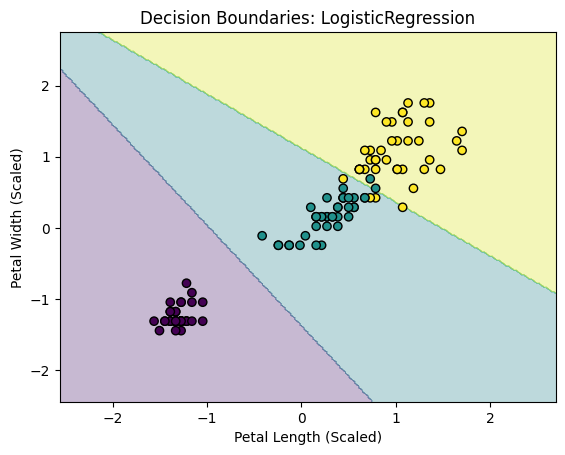

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boundaries(X, y, model, scaler):
    # Only use two features for visualization (Petal Length, Petal Width)
    X_vis = X[:, 2:] 
    
    # We must scale the visualization data exactly like the training data
    # Note: In a real project, you'd fit the scaler on X_train_vis
    X_scaled = scaler.fit_transform(X_vis)
    model.fit(X_scaled, y)

    # Create a grid to plot in
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict across the entire grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k')
    plt.xlabel('Petal Length (Scaled)')
    plt.ylabel('Petal Width (Scaled)')
    plt.title(f"Decision Boundaries: {type(model).__name__}")
    plt.show()

# Example usage with your Logistic Regression
plot_boundaries(X_train, y_train, LogisticRegression(), StandardScaler())

### SVM and RandomForest implementation

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [68]:
# --- 1. SVM Pipeline & Grid Search ---
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Parameters to test: 'C' is regularization, 'kernel' is the shape of the boundary
svm_params = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf']
}

svm_grid = GridSearchCV(svm_pipe, svm_params, cv=5)
svm_grid.fit(X_train_clean, y_train_clean)

# --- 2. Random Forest Pipeline & Grid Search ---
rf_pipe = Pipeline([
    ('scaler', StandardScaler()), # RF doesn't strictly need scaling, but it's good practice for consistency
    ('rf', RandomForestClassifier(random_state=42))
])

# Parameters to test: n_estimators is the number of trees
rf_params = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 5, 10]
}

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5)
rf_grid.fit(X_train_clean, y_train_clean)

print(f"Best SVM Score: {svm_grid.best_score_:.2%}")
print(f"Best RF Score: {rf_grid.best_score_:.2%}")

Best SVM Score: 95.65%
Best RF Score: 95.61%


In industry, a single accuracy number isn't enough. We use a Confusion Matrix to see exactly where the model is making mistakes and a Classification Report to check precision and recall for each flower species.

--- SVM Final Report ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


--- Random Forest Final Report ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



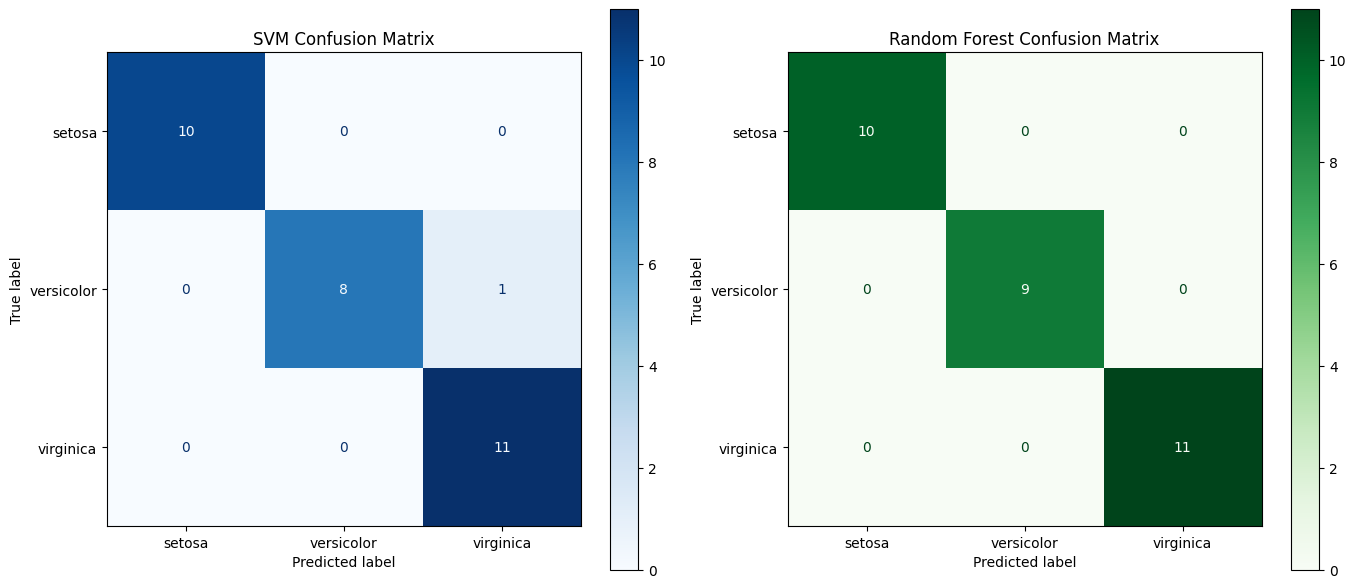

In [69]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1. Evaluate the SVM
svm_preds = svm_grid.predict(X_test)
print("--- SVM Final Report ---")
print(classification_report(y_test, svm_preds, target_names=iris_data.target_names))

# 2. Evaluate the Random Forest
rf_preds = rf_grid.predict(X_test)
print("\n--- Random Forest Final Report ---")
print(classification_report(y_test, rf_preds, target_names=iris_data.target_names))

# 3. Visualize Confusion Matrices Side-by-Side
# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot SVM on the first axis (ax[0])
ConfusionMatrixDisplay.from_estimator(
    svm_grid, 
    X_test, 
    y_test, 
    display_labels=iris_data.target_names, 
    cmap='Blues', 
    ax=ax[0]
)
ax[0].set_title("SVM Confusion Matrix")

# Plot Random Forest on the second axis (ax[1])
ConfusionMatrixDisplay.from_estimator(
    rf_grid, 
    X_test, 
    y_test, 
    display_labels=iris_data.target_names, 
    cmap='Greens', 
    ax=ax[1]
)
ax[1].set_title("Random Forest Confusion Matrix")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Visualizing Decision Boundaries of SVC and RF

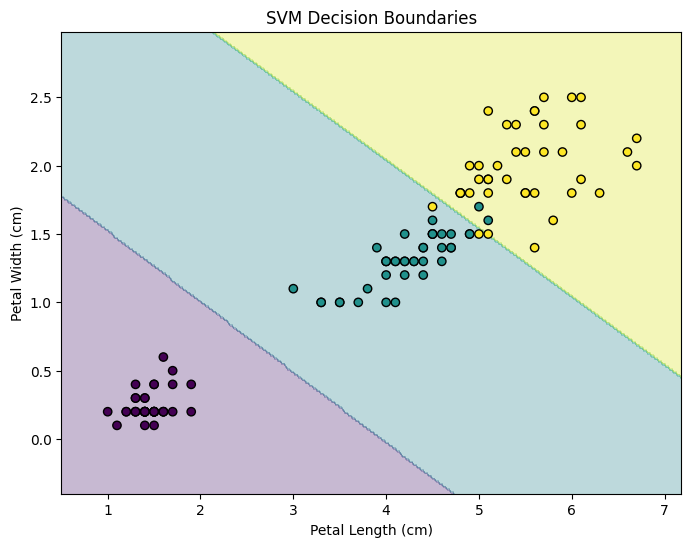

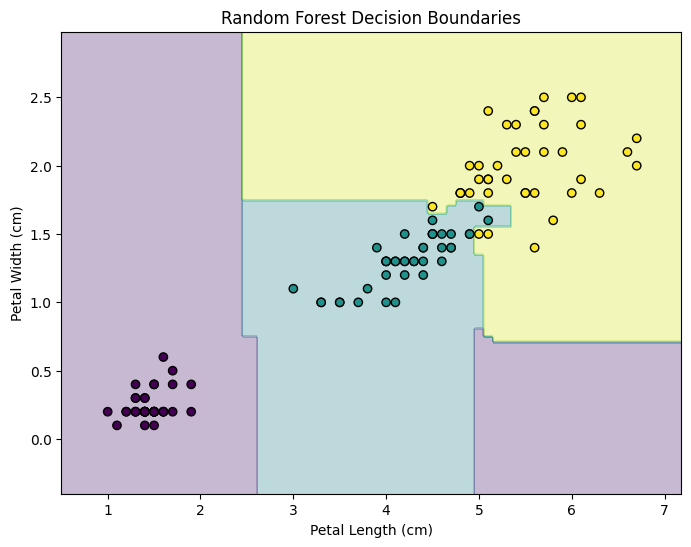

In [70]:
import numpy as np

def plot_decision_boundaries(X, y, pipeline, title):
    # Select only Petal Length (index 2) and Petal Width (index 3)
    X_vis = X[:, 2:]
    
    # We must RE-FIT a version of the pipeline with only 2 features for plotting
    # We use the best parameters found by GridSearchCV
    vis_pipeline = pipeline.set_params() 
    vis_pipeline.fit(X_vis, y)

    # Create a mesh grid
    x_min, x_max = X_vis[:, 0].min() - 0.5, X_vis[:, 0].max() + 0.5
    y_min, y_max = X_vis[:, 1].min() - 0.5, X_vis[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predict across the grid
    Z = vis_pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolors='k', cmap='viridis')
    plt.title(title)
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")
    plt.show()

# Visualize your two optimized models
plot_decision_boundaries(X_train, y_train, svm_grid.best_estimator_, "SVM Decision Boundaries")
plot_decision_boundaries(X_train, y_train, rf_grid.best_estimator_, "Random Forest Decision Boundaries")

### Deploying the model using FastAPI (example)

In [ ]:
# Step 1: Save the Model (Pickling)
# In your notebook, you need to save your trained best_estimator_ to a file. This is called "Serializing."

import joblib

# Save the best SVM pipeline (includes the scaler!)
joblib.dump(svm_grid.best_estimator_, 'iris_model_pipeline.pkl')

['iris_model_pipeline.pkl']

In [ ]:
# Step 2: Create the FastAPI Application
# Create a new file named main.py. This script will act as the "waiter" in a restaurant: it takes an order (flower measurements), brings it to the chef (the model), and returns the result (the species).

from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# 1. Load the saved pipeline
model = joblib.load('iris_model_pipeline.pkl')
target_names = ['setosa', 'versicolor', 'virginica']

app = FastAPI()

# 2. Define the input format using Pydantic
class IrisInput(BaseModel):
    sepal_length: float
    sepal_width: float
    petal_length: float
    petal_width: float

@app.get("/")
def home():
    return {"message": "Iris Classification API is Online"}

@app.post("/predict")
def predict(iris: IrisInput):
    # Convert input data to the format the model expects
    data = np.array([[iris.sepal_length, iris.sepal_width, 
                      iris.petal_length, iris.petal_width]])
    
    # The pipeline automatically scales the data before predicting!
    prediction = model.predict(data)
    species = target_names[int(prediction[0])]
    
    return {"species": species}

In [ ]:
# Step 3: Run the API
# To run this, you need the uvicorn server. Open your terminal and type:

pip install fastapi uvicorn joblib scikit-learn
uvicorn main:app --reload